<a href="https://colab.research.google.com/github/walaashaabanAI/Amazon-Review-LSTM/blob/main/Amazon_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

import re
import warnings
warnings.filterwarnings('ignore')




In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
nltk.download('all')
stopwords = set(stopwords.words('english'))
stopwords = [stopword for stopword in stopwords if stopword not in ['no', 'not', 'nor']]

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

# **Read data**

In [ ]:
train = open('/content/train.ft.txt').read().split('__label__')[1:]
test = open('/content/test.ft.txt').read().split('__label__')[1:]

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(len(train)):
  X_train.append(train[i][1:])
  y_train.append(train[i][:1])

for j in range(len(test)):
  X_test.append(test[j][1:])
  y_test.append(test[j][:1])

In [ ]:
df_train = pd.DataFrame({'Review':X_train, 'label':y_train})
df_test = pd.DataFrame({'Review':X_test, 'label':y_test})

In [ ]:
y_train = [0 if label == '1' else 1 for label in y_train]
y_test= [0 if label == '1' else 1 for label in y_test]

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
df_train.head()

,Review,label
0,Stuning even for the non-gamer: This sound tr...,2
1,The best soundtrack ever to anything.: I'm re...,2
2,Amazing!: This soundtrack is my favorite musi...,2
3,Excellent Soundtrack: I truly like this sound...,2
4,"Remember, Pull Your Jaw Off The Floor After H...",2


In [ ]:
df_train.shape, df_test.shape

((23423, 2), (25427, 2))

visualization data

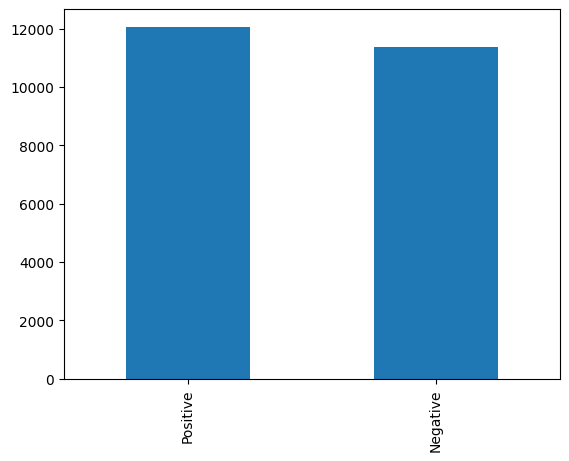

In [31]:
df_train['label'].apply(lambda x :"Negative" if x is '1' else  "Positive").value_counts().plot(kind='bar');


In [ ]:
lem = WordNetLemmatizer()
pr = PorterStemmer()
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', " ", text)
    text = re.sub(r'https\S+', " ", text)
    text = re.sub(r'[^a-zA-Z0-9]', " ", text)
    text = ' '.join([lem.lemmatize(pr.stem(word)) for word in text.split() if word not in stopwords])
    return text

In [ ]:
df_train['Review'] = df_train['Review'].apply(lambda x : clean_text(x))
df_test['Review'] = df_test['Review'].apply(lambda x : clean_text(x))

In [ ]:
max_words = 1000
max_sequence_length = 100

tokenizer = Tokenizer()

tokenizer.fit_on_texts(df_train['Review'])
tokenizer.fit_on_texts(df_test['Review'])

train_seq = tokenizer.texts_to_sequences(df_train['Review'])
test_seq = tokenizer.texts_to_sequences(df_test['Review'])

X_train = pad_sequences(train_seq, maxlen=max_sequence_length)
X_test = pad_sequences(test_seq, maxlen=max_sequence_length)



In [ ]:
voc_size = len(tokenizer.word_index) +1
print(voc_size)

55019


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=voc_size, output_dim=128, input_length=max_sequence_length))
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          7042432   
                                                                 
 lstm (LSTM)                 (None, 100, 128)          131584    
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=7)

Epoch 1/7
732/732 [==============================] - 190s 251ms/step - loss: 0.3976 - accuracy: 0.8204
Epoch 2/7
732/732 [==============================] - 182s 249ms/step - loss: 0.2049 - accuracy: 0.9232
Epoch 3/7
732/732 [==============================] - 182s 249ms/step - loss: 0.1197 - accuracy: 0.9582
Epoch 4/7
732/732 [==============================] - 183s 249ms/step - loss: 0.0829 - accuracy: 0.9720
Epoch 5/7
732/732 [==============================] - 182s 248ms/step - loss: 0.0494 - accuracy: 0.9841
Epoch 6/7
732/732 [==============================] - 185s 252ms/step - loss: 0.0333 - accuracy: 0.9898
Epoch 7/7
732/732 [==============================] - 192s 262ms/step - loss: 0.0275 - accuracy: 0.9915


In [18]:
print(X_train.shape)
print(y_train.shape)

(23423, 100)
(23423, 2)


In [19]:
print(X_test.shape)
print(y_test.shape)

(25427, 100)
(25427, 2)


In [20]:
loss,accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

795/795 [==============================] - 74s 91ms/step - loss: 0.7059 - accuracy: 0.8466
Loss: 0.7059196829795837
Accuracy: 0.846619725227356


In [21]:
prediction=model.predict(X_test)
y_pred=np.where(prediction>=.5,1,0)


795/795 [==============================] - 74s 92ms/step


In [22]:
y_pred = list(np.argmax(y_pred, axis = 1))
y_test = list(np.argmax(y_test, axis = 1))
# print(y_test)

In [23]:
df=pd.DataFrame({'actual':y_test, 'pred':y_pred})

In [24]:
df.head()

,actual,pred
0,1,1
1,1,1
2,0,0
3,1,1
4,1,1


In [26]:
print(classification_report(df['actual'], df['pred']))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     12375
           1       0.86      0.84      0.85     13052

    accuracy                           0.85     25427
   macro avg       0.85      0.85      0.85     25427
weighted avg       0.85      0.85      0.85     25427



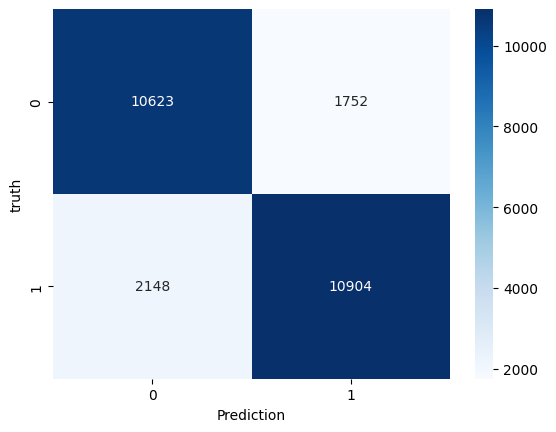

In [27]:
cm = confusion_matrix(df['actual'], df['pred'])
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('truth')
plt.show()
